In [1]:
import tensorflow as tf
# Enable mixed precision if supported
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Set custom configurations
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

# Set environment variables to manage cuDNN behavior
import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# Define data paths
csv_file = "/kaggle/input/airbus-ship-detection/train_ship_segmentations_v2.csv"
root_dir = "/kaggle/input/airbus-ship-detection/train_v2/"

2024-07-30 08:13:34.647615: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 08:13:34.647736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 08:13:34.810158: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def rle_decode(mask_rle, target_size=(768, 768)):
    if pd.isna(mask_rle) or mask_rle == '':
        return np.zeros(target_size, dtype=np.uint8)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(np.prod(target_size), dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(target_size, order='F')

class CustomDataGenerator(Sequence):
    def __init__(self, csv_file, root_dir, batch_size=4, original_size=(768, 768), target_size=(256, 256), ship_ratio=0.95, shuffle=True, indices=None, **kwargs):
        super().__init__(**kwargs)
        
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.original_size = original_size
        self.target_size = target_size
        self.ship_ratio = ship_ratio
        self.shuffle = shuffle
        
        if indices is not None:
            self.data = self.data.iloc[indices].reset_index(drop=True)
        
        images_with_ship = self.data[self.data['EncodedPixels'].notnull()]
        num_images_with_ship = len(images_with_ship)
        
        num_images_without_ship = int(num_images_with_ship * (1 - ship_ratio) / ship_ratio)
        num_images_without_ship = max(num_images_without_ship, 1)
        
        images_without_ship = self.data[self.data['EncodedPixels'].isnull()].sample(
            n=num_images_without_ship, random_state=42, replace=False)
        
        self.data = pd.concat([images_with_ship, images_without_ship], ignore_index=True)
        
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_data = self.data.iloc[batch_indexes]
        
        images = np.zeros((len(batch_data), *self.target_size, 3), dtype=np.float32)
        masks = np.zeros((len(batch_data), *self.target_size, 1), dtype=np.uint8)
        
        for i, (_, row) in enumerate(batch_data.iterrows()):
            img_name = os.path.join(self.root_dir, row['ImageId'])
            image = load_img(img_name, target_size=self.original_size)
            image = img_to_array(image) / 255.0
            
            mask_str = row['EncodedPixels']
            mask = rle_decode(mask_str, target_size=self.original_size)
            mask = np.expand_dims(mask, axis=-1)
            
            # Resize images and masks
            image = tf.image.resize(image, self.target_size).numpy()
            mask = tf.image.resize(mask, self.target_size, method=tf.image.ResizeMethod.NEAREST_NEIGHBOR).numpy()
            
            images[i] = image
            masks[i] = mask
        
        return images, masks
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)


In [3]:
# Create data generators
full_data_generator = CustomDataGenerator(csv_file, root_dir, target_size=(256, 256))

# Split data
num_samples = len(full_data_generator.data)
indices = np.arange(num_samples)
np.random.shuffle(indices)
split_index = int(num_samples * 0.9)

train_indices = indices[:split_index]
val_indices = indices[split_index:]

# Create train and validation generators with the split indices
train_generator = CustomDataGenerator(csv_file=csv_file, root_dir=root_dir, batch_size=16, target_size=(256, 256), ship_ratio=0.8, shuffle=True, indices=train_indices)
val_generator = CustomDataGenerator(csv_file=csv_file, root_dir=root_dir, batch_size=16, target_size=(256, 256), ship_ratio=0.8, shuffle=True, indices=val_indices)

In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, Conv2DTranspose, BatchNormalization

def UNet(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)
    
    # Downsampling path
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D((2, 2))(drop4)
    
    # Upsampling path
    up5 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(pool4)
    up5 = concatenate([up5, drop4], axis=3)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(up5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    
    up6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5)
    up6 = concatenate([up6, conv3], axis=3)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    
    up7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = concatenate([up7, conv2], axis=3)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    
    up8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = concatenate([up8, conv1], axis=3)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(16, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)
    
    # Final convolutional layer
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(conv8)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

model = UNet()

In [5]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │      2,320 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │      9,248 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │     73,856 │ max_pooling2d_2[

 Total params: 994,161 (3.79 MB)

 Trainable params: 992,241 (3.79 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + K.sum(y_pred, axis=[1, 2, 3])
    dice = (2. * intersection + smooth) / (union + smooth)
    return dice

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

def binary_crossentropy_with_dice_loss(y_true, y_pred):
    return K.binary_crossentropy(y_true, y_pred) + (1 - dice_coef(y_true, y_pred))


In [7]:
metrics = ['accuracy', dice_coef, dice_loss]

model.compile(optimizer=Adam(learning_rate=0.00025), loss=binary_crossentropy_with_dice_loss, metrics=metrics)

In [8]:
# Training loop
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('/kaggle/working/unet_model_sr08_dc.weights.h5', verbose=1, save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.TensorBoard(log_dir='/kaggle/working/logs')
]

history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=callbacks
)

Epoch 1/10


I0000 00:00:1722327261.487174     107 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2145/2145 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.9017 - dice_coef: 0.0134 - dice_loss: 0.9866 - loss: 1.3766
Epoch 1: val_loss improved from inf to 0.92658, saving model to /kaggle/working/unet_model_sr08_dc.weights.h5
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 1086s 492ms/step - accuracy: 0.9017 - dice_coef: 0.0135 - dice_loss: 0.9865 - loss: 1.3765 - val_accuracy: 0.9917 - val_dice_coef: 0.1190 - val_dice_loss: 0.8810 - val_loss: 0.9266
Epoch 2/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9954 - dice_coef: 0.1915 - dice_loss: 0.8085 - loss: 0.8318
Epoch 2: val_loss improved from 0.92658 to 0.64051, saving model to /kaggle/working/unet_model_sr08_dc.weights.h5
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 764s 355ms/step - accuracy: 0.9954 - dice_coef: 0.1916 - dice_loss: 0.8084 - loss: 0.8318 - val_accuracy: 0.9970 - val_dice_coef: 0.3893 - val_dice_loss: 0.6107 - val_loss: 0.6405
Epoch 3/10
2145/2145 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.9966 - dice_coef: 0.4162 - dice_lo

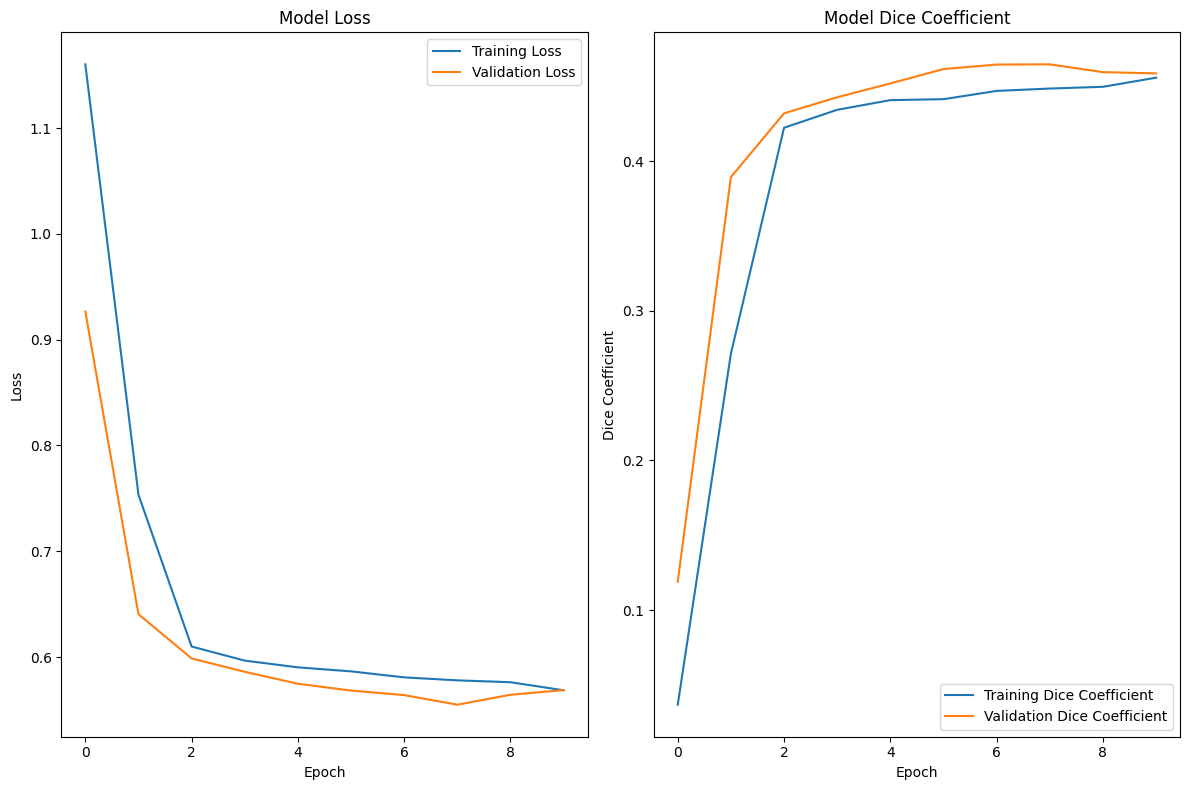

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation dice coefficient values
plt.subplot(1, 2, 2)
plt.plot(history.history['dice_coef'], label='Training Dice Coefficient')
plt.plot(history.history['val_dice_coef'], label='Validation Dice Coefficient')
plt.title('Model Dice Coefficient')
plt.xlabel('Epoch')
plt.ylabel('Dice Coefficient')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()